In [1]:
from fenics import *
import matplotlib.pyplot as plt
%matplotlib notebook

nx = 1000               # number of mesh points
x0, xf = (-1.0, 1.0)  # x boundaries
T = 1.0               # final time
nSteps = 1000          # number of time steps
dt = T/nSteps         # step size
order = 3             # mesh polynomial order

mesh = IntervalMesh(nx, x0, xf)
V = FunctionSpace(mesh, "CG", order)

In [2]:
# boundary conditions
def inside(x, on_boundary):
    return on_boundary
bc = DirichletBC(V, Constant(0), inside)

# initial conditions
u_0 = Expression('-sin(pi*x[0])', degree=1)
u_n = interpolate(u_0, V)

# define variational problem
u = Function(V)
v = TestFunction(V)

u_x = u.dx(0)
alpha = Constant(1/(100*pi))
f = Expression("0.0", degree=0)
DT = Constant(dt)

In [3]:
# Advective flux of conservation law:
e0 = Constant((1,))
def flux(u):
    # Vector of dimension 1, for consistency w/ grad, div
    return 0.5*u*u*e0

# Advection velocity for a general hyperbolic conservation law:
u_var = variable(u)
a = diff(flux(u_var),u_var)

# Limit explosion of automatically-determined quadrature degree; just try to get the
# advection term exactly:
dx = dx(metadata={"quadrature_degree":3*order-1})

# Galerkin part of weak problem:
F_Gal = (dot(u - u_n, v)/DT
         - dot(flux(u),grad(v))
         + alpha*dot(grad(u), grad(v))
         - dot(f, v))*dx

# Residual of strong problem:
res_strong = (u-u_n)/DT + div(flux(u) - alpha*grad(u)) - f

# SUPG stabilization:
h = CellDiameter(mesh)
C_inv = Constant(6)
C_t = Constant(2)
tau_adv = h/(2*sqrt(dot(a,a) + DOLFIN_EPS))
tau_diff = h*h/(C_inv*alpha + DOLFIN_EPS)
tau_t = DT/C_t
tau = 1.0/sqrt(tau_adv**(-2) + tau_diff**(-2) + tau_t**(-2))
F_SUPG = tau*res_strong*dot(a,grad(v))*dx

# Combined formulation; comment out `+ F_SUPG` with
# `alpha = Constant(DOLFIN_EPS)` to see effect of stabilization.
F = F_Gal + F_SUPG

<IPython.core.display.Javascript object>


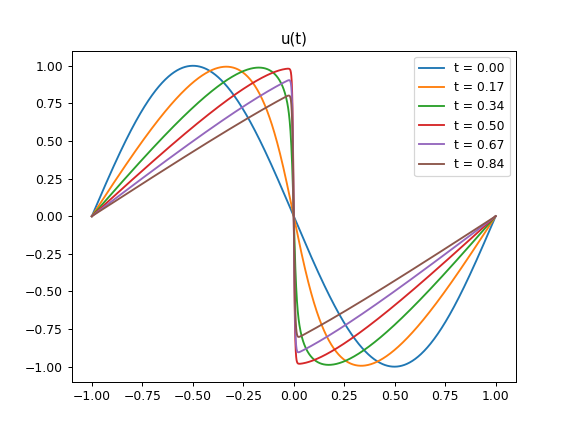

0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000


In [4]:
labels = []
t = 0
for n in range(nSteps):
    
    # update time
    t += dt

    # solve variational problem
    solve(F_Gal == 0, u, bc)
    
    # update previous solution
    u_n.assign(u)
    
    # plot 6 solution snapshots
    if n % round(nSteps/6,0) == 0:
        plt.figure(1)
        plot(u, title="u(t)")
        labels.append(f"t = {t/T:.2f}")
    
    # print progress
    if n % round(nSteps/10,0) == 0:
        print(f"{n} / {nSteps}")
        
    
plt.legend(labels, loc='upper right')
plt.show()